# Customer Churn Prediction Modelling

## Step 1: Import libraries

In [9]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from imblearn.over_sampling import SMOTE

from sklearn import preprocessing, ensemble  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.naive_bayes import GaussianNB  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.ensemble import AdaBoostClassifier  
from sklearn.ensemble import ExtraTreesClassifier  
from sklearn.ensemble import BaggingClassifier  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.svm import SVC
from sklearn import metrics

import keras
import keras_metrics
from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Step 2: Read csv file and explore variables

In [10]:
custchurn=pd.read_csv("C:\\Users\\wongannnee\\Google Drive\\ytd_churn_data.csv") 
pd.set_option('display.max_column',None)


In [4]:
# 2-1:  Total records & variables, data types, unique values, missing values, first 5 records

def checktable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Variable'] = summary['index']
    summary = summary[['Variable','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['1st Record'] = df.loc[0].values
    summary['2nd Record'] = df.loc[1].values
    summary['3rd Record'] = df.loc[2].values
    summary['4th Record'] = df.loc[3].values
    summary['5th Record'] = df.loc[4].values
    return summary

checktable(custchurn)

Dataset Shape: (7043, 21)


,Variable,dtypes,Missing,Uniques,1st Record,2nd Record,3rd Record,4th Record,5th Record
0,customerID,object,0,7043,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
1,gender,object,0,2,Female,Male,Male,Male,Female
2,SeniorCitizen,int64,0,2,0,0,0,0,0
3,Partner,object,0,2,Yes,No,No,No,No
4,Dependents,object,0,2,No,No,No,No,No
5,tenure,int64,0,73,1,34,2,45,2
6,PhoneService,object,0,2,No,Yes,Yes,No,Yes
7,MultipleLines,object,0,3,No phone service,No,No,No phone service,No
8,InternetService,object,0,3,DSL,DSL,DSL,DSL,Fiber optic
9,OnlineSecurity,object,0,3,No,Yes,Yes,Yes,No


In [5]:
# 2-2: Chech the number of yes and no for imbalanced classification target variable in'Churn'
pd.value_counts(custchurn.Churn)


No     5174
Yes    1869
Name: Churn, dtype: int64

### Step 3: Exploratory Data Analysis

In [6]:
#3-1: Change 'SeniorCitizen' from interger to categorical variable
custchurn['SeniorCitizen']=pd.Categorical(custchurn['SeniorCitizen'])
print(custchurn.dtypes)


customerID            object
gender                object
SeniorCitizen       category
Partner               object
Dependents            object
tenure                 int64
PhoneService          object
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling      object
PaymentMethod         object
MonthlyCharges       float64
TotalCharges         float64
Churn                 object
dtype: object


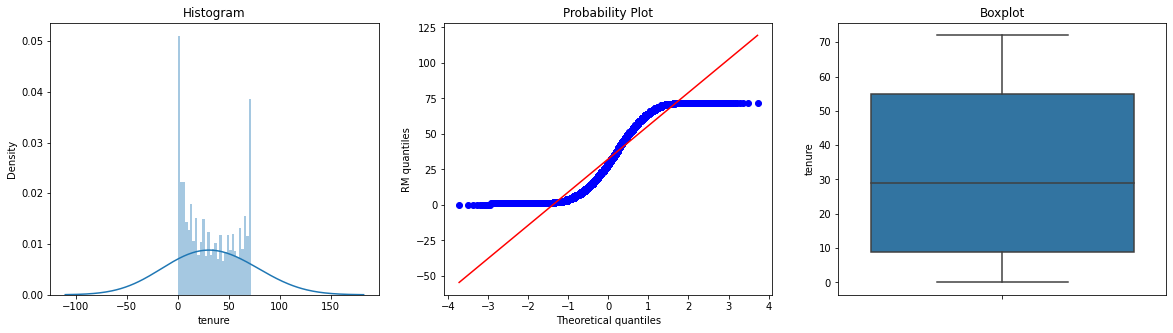

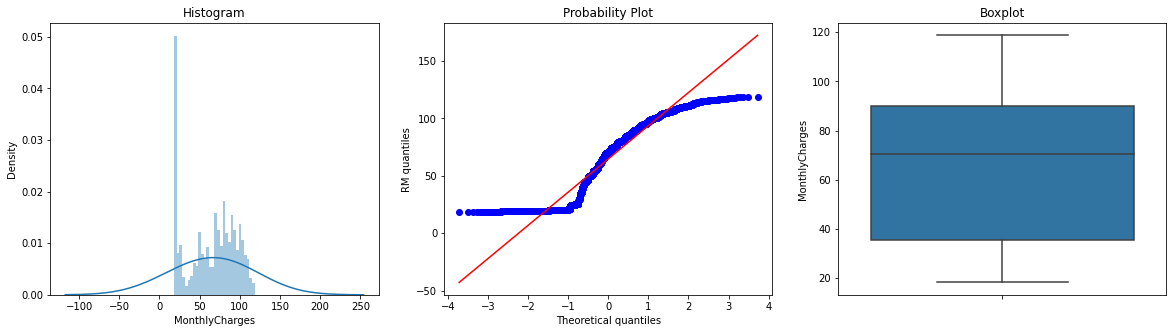

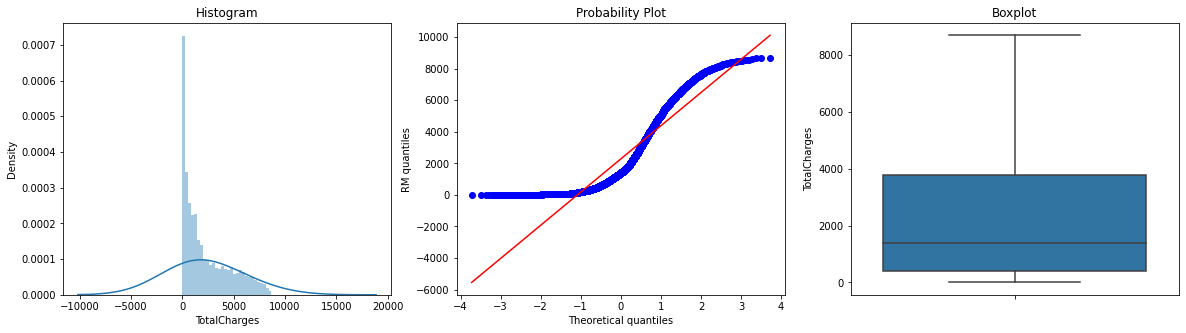

In [6]:
# 3-2: Plot Numerical Variables - Histogram, Probablity Plot, Box plot

def diagnostic_plots(df, variable):
    
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30,kde_kws={'bw': 1.5})
    plt.title('Histogram')
    
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()
    

num_columns=custchurn.select_dtypes(exclude=["object","category"]).columns
for i in num_columns:
    diagnostic_plots(custchurn,i)
    

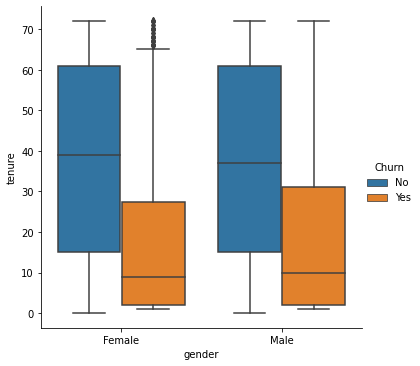

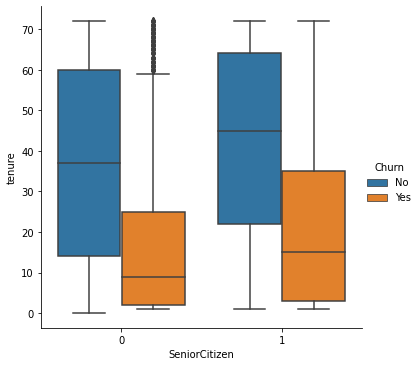

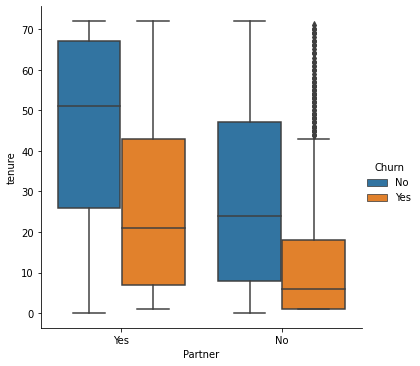

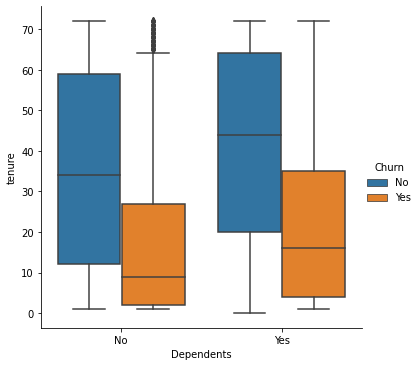

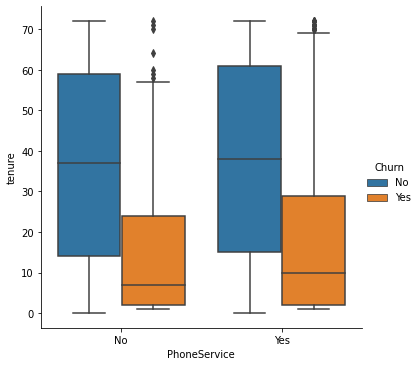

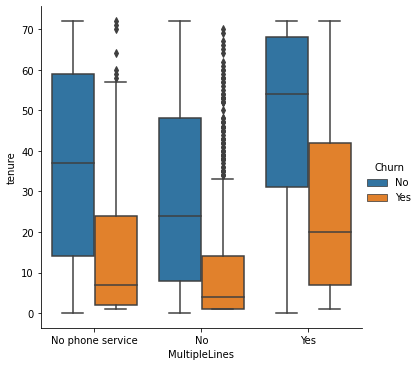

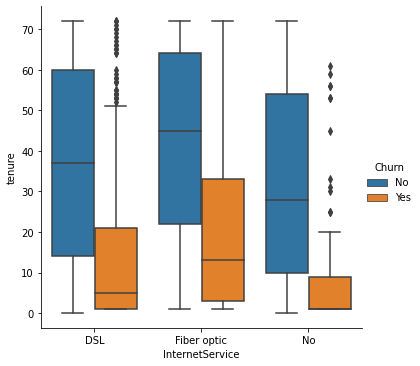

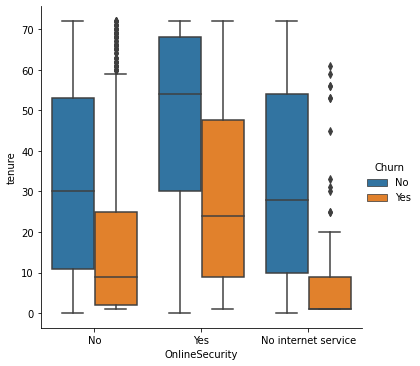

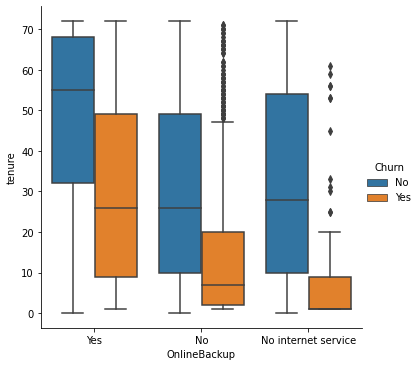

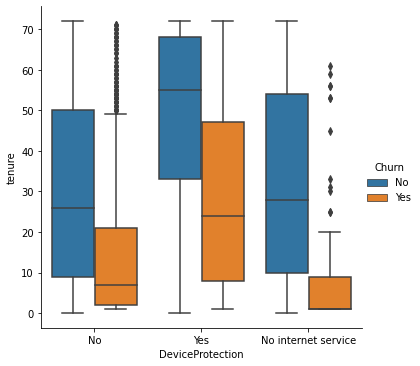

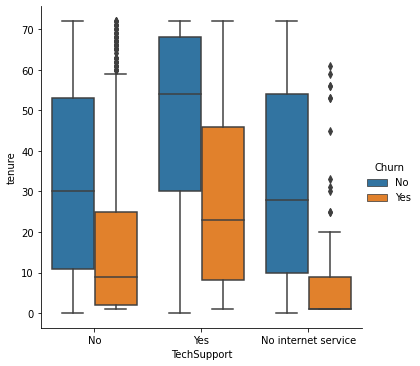

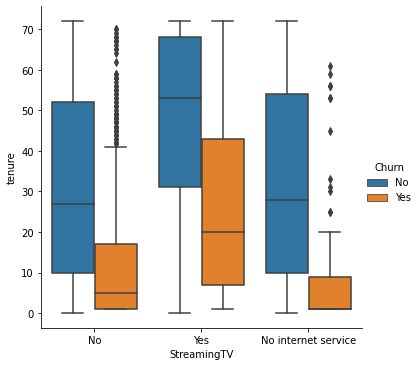

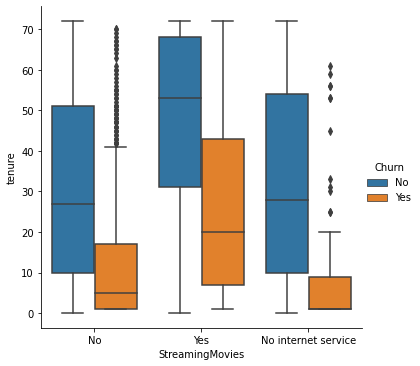

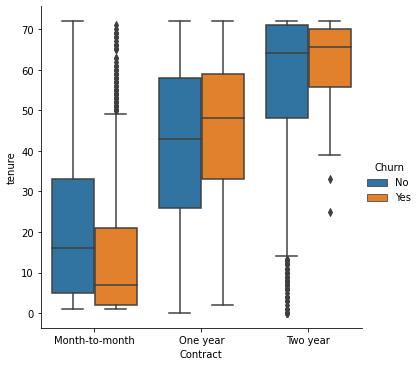

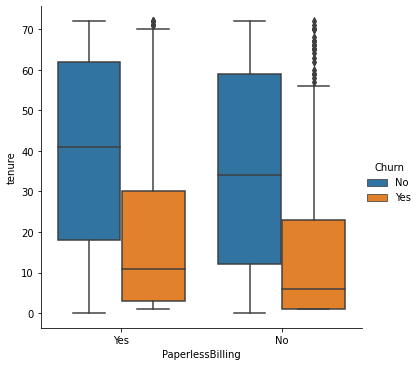

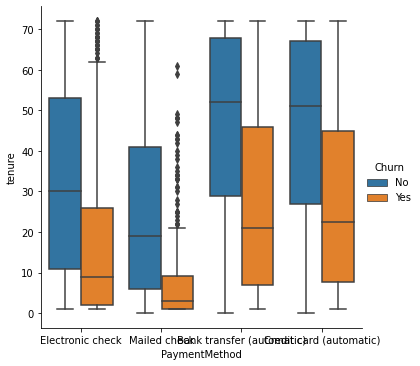

In [7]:
# 3-3: Plot Categorical variables excluding 'int' and 'float' object datatype, and 'customerID'


cat_columns=custchurn.select_dtypes(exclude=['int64','float']).columns
cat_columns=cat_columns.drop(['customerID'])

for i in cat_columns[:-1]:
    sns.catplot(x=i,y="tenure",hue="Churn",data=custchurn,kind="box",aspect=1);
    
    

### Step 4: Data preprocessing

In [7]:
#4-1: Replace target variable 'Churn' from 'Yes=1, 'No'=0, and drop 'customerID'

custchurn['Churn'].replace(to_replace='Yes', value=1, inplace=True)
custchurn['Churn'].replace(to_replace='No',  value=0, inplace=True)
custchurn=custchurn.drop(['customerID'], axis=1)


In [8]:
#4-2: Change 16 categorical to dummy variables

custchurn_dummy = pd.get_dummies(custchurn)
print(f"Dataset Total records, Total variables: {custchurn_dummy.shape}")
custchurn_dummy.head()

Dataset Total records, Total variables: (7043, 47)


,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [23]:
#4-3: Normalise 3 numerical variables
#from sklearn.preprocessing import StandardScaler

num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']

scaler= StandardScaler()
custchurn_dummy[num_cols] = scaler.fit_transform(custchurn_dummy[num_cols])
custchurn_dummy.head(20)

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.277445,-1.160323,-0.992611,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0.066327,-0.259629,-0.172165,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,-1.236724,-0.362660,-0.958066,1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0.514251,-0.746535,-0.193672,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,-1.236724,0.197365,-0.938874,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
5,-0.992402,1.159546,-0.643789,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
6,-0.422317,0.808907,-0.145738,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0
7,-0.910961,-1.163647,-0.872587,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
8,-0.177995,1.330711,0.338085,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
9,1.206498,-0.286218,0.533044,0,0,1,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0


<AxesSubplot:>

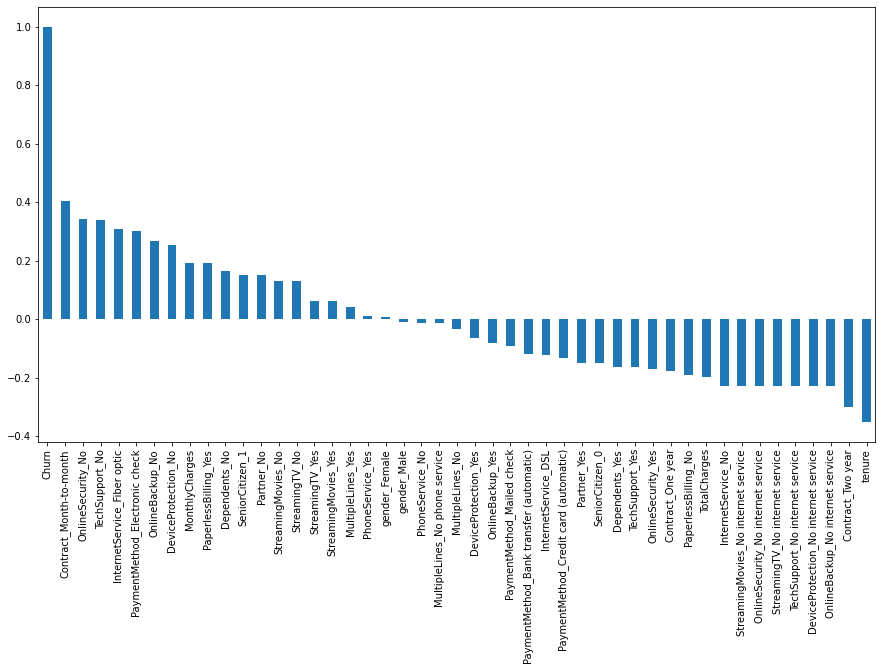

In [8]:
# 4-4: Plot Correlation of 'Churn' with other variables

corr = custchurn_dummy.corr()

plt.figure(figsize=(15,8))
corr['Churn'].sort_values(ascending = False).plot(kind='bar')


<AxesSubplot:>

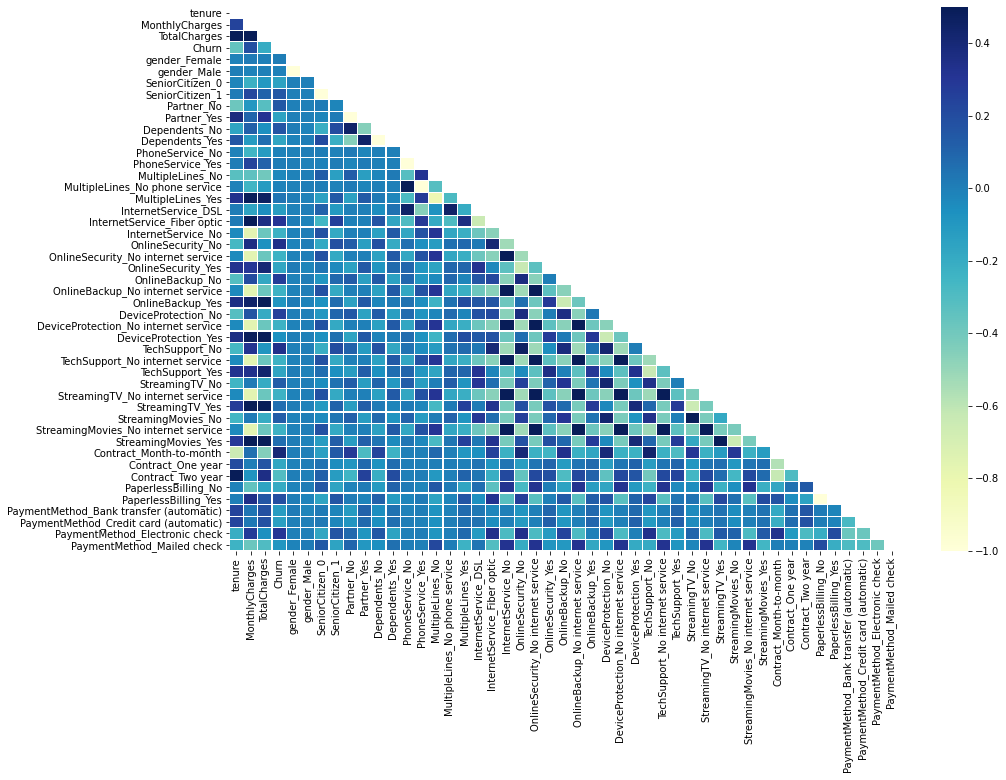

In [12]:
# 4-5: Plot Heatmap of Correlation of 'Churn' with other variables

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr,
            vmax=.5,
            mask=mask,
            #annot=True, fmt='.2f',
            linewidths=.2, cmap="YlGnBu")


In [24]:
#4-6: Split to test and train dataset 70:30 ratio, check ratio of 0 and 1 in target variable

x=custchurn_dummy.drop(['Churn'], axis=1)
y=custchurn_dummy.Churn
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=0)

print("x_train, x_test:", x_train.shape, x_test.shape)
print("y_train, y_test:", y_train.shape, y_test.shape)
print(y_train.value_counts(), '\n', y_test.value_counts())


x_train, x_test: (4930, 46) (2113, 46)
y_train, y_test: (4930,) (2113,)
0    3614
1    1316
Name: Churn, dtype: int64 
 0    1560
1     553
Name: Churn, dtype: int64


In [25]:
#4-7: Use SMOTE oversampling for unbalance training dataset

smt = SMOTE()
x1_train, y1_train = smt.fit_sample(x_train, y_train)
y1_train = y1_train.astype(int)

print("x1_train", x1_train.shape)
print("y1_train", y1_train.shape)
print(y1_train.value_counts())


x1_train (7228, 46)
y1_train (7228,)
1    3614
0    3614
Name: Churn, dtype: int64


### Step 4: Model Training and Validation 

In [16]:
# 4-1: The shallow learning models to be used
models = []
model1 = GradientBoostingClassifier()
model2 = DecisionTreeClassifier()
model3 = RandomForestClassifier()
model4 = LogisticRegression(max_iter=1000)
model5 = GaussianNB()
model6 = ExtraTreesClassifier()
model7 = BaggingClassifier()
model8 = AdaBoostClassifier()
model9 = KNeighborsClassifier()
model10 = SVC(kernel = "linear")
model11 = SVC(kernel = "rbf")
model12 = SVC(kernel = "poly")
model13 = SVC(kernel = "sigmoid")
                   
model_list = {'GB': model1, 'DT': model2, 'RF': model3,'LR': model4, 'GN': model5, 'ET': model6, 'BG': model7, 'AB': model8, 'KNN':model9, 'SVCLinear':model10, 'SVCrbf':model11, 'SVCpoly':model12,'SVCsigmoid':model13}



In [17]:
# 4-2: Training on normal training dataset and Evaluation on Test dataset

result=pd.DataFrame()
results = pd.DataFrame()

for key in model_list:
    model = model_list[key].fit(x_train, y_train)
    start1=time.time()
    predictions_tr = model.predict(x_train)
    end1=time.time()
    train_time=end1-start1
    
    start2=time.time()
    predictions_te = model.predict(x_test)
    end2=time.time()
    test_time=end2-start2

    accuracy_tr = accuracy_score(y_train, predictions_tr)
    recall_tr = recall_score(y_train, predictions_tr)
    accuracy_tr = float("{0:.3f}".format(accuracy_tr))
    recall_tr = float("{0:.3f}".format(recall_tr))
    accuracy_te = accuracy_score(y_test, predictions_te)
    recall_te = recall_score(y_test, predictions_te)
    accuracy_te = float("{0:.3f}".format(accuracy_te))
    recall_te = float("{0:.3f}".format(recall_te))
    train_time = float("{0:.3f}".format(train_time))
    test_time = float("{0:.3f}".format(test_time))
    
    result = pd.DataFrame({"model":[key], "train_acc":[accuracy_tr], "train_recall":[recall_tr], "test_acc":[accuracy_te], "test_recall":[recall_te], "train_time":[train_time],"test_time":[test_time]})
    results = results.append(result,ignore_index = True)
    
print(results)

results.to_csv(r"C:\\Users\\wongannnee\\Google Drive\\results.csv", index = False)


         model  train_acc  train_recall  test_acc  test_recall  train_time  \
0           GB      0.834         0.593     0.799        0.539       0.021   
1           DT      0.997         0.990     0.720        0.479       0.005   
2           RF      0.997         0.993     0.783        0.472       0.114   
3           LR      0.806         0.559     0.802        0.541       0.007   
4           GN      0.707         0.838     0.699        0.828       0.015   
5           ET      0.997         0.990     0.762        0.445       0.197   
6           BG      0.979         0.932     0.779        0.450       0.061   
7           AB      0.813         0.567     0.798        0.552       0.101   
8          KNN      0.840         0.666     0.760        0.523       1.583   
9    SVCLinear      0.798         0.537     0.799        0.521       0.676   
10      SVCrbf      0.821         0.534     0.799        0.490       0.884   
11     SVCpoly      0.828         0.557     0.792        0.488  

In [18]:
# 4-3: Training on SMOTE training dataset and Evaluation on Test dataset

result=pd.DataFrame()
results = pd.DataFrame()

for key in model_list:
    model = model_list[key].fit(x1_train, y1_train)
    start1=time.time()
    predictions_tr = model.predict(x1_train)
    end1=time.time()
    train_time=end1-start1
    
    start2=time.time()
    predictions_te = model.predict(x_test)
    end2=time.time()
    test_time=end2-start2

    accuracy_tr = accuracy_score(y1_train, predictions_tr)
    recall_tr = recall_score(y1_train, predictions_tr)
    accuracy_tr = float("{0:.3f}".format(accuracy_tr))
    recall_tr = float("{0:.3f}".format(recall_tr))
    accuracy_te = accuracy_score(y_test, predictions_te)
    recall_te = recall_score(y_test, predictions_te)
    accuracy_te = float("{0:.3f}".format(accuracy_te))
    recall_te = float("{0:.3f}".format(recall_te))
    train_time = float("{0:.3f}".format(train_time))
    test_time = float("{0:.3f}".format(test_time))
    
    result = pd.DataFrame({"model":[key], "train_acc":[accuracy_tr], "train_recall":[recall_tr], "test_acc":[accuracy_te], "test_recall":[recall_te], "train_time":[train_time],"test_time":[test_time]})
    results = results.append(result,ignore_index = True)
    
print(results)

results.to_csv(r"C:\\Users\\wongannnee\\Google Drive\\results1.csv", index = False)


         model  train_acc  train_recall  test_acc  test_recall  train_time  \
0           GB      0.855         0.881     0.779        0.680       0.036   
1           DT      0.998         0.996     0.713        0.541       0.010   
2           RF      0.998         0.999     0.770        0.599       0.174   
3           LR      0.847         0.845     0.796        0.644       0.005   
4           GN      0.767         0.851     0.711        0.803       0.021   
5           ET      0.998         0.996     0.752        0.468       0.208   
6           BG      0.989         0.984     0.769        0.562       0.062   
7           AB      0.819         0.856     0.763        0.741       0.150   
8          KNN      0.893         0.955     0.719        0.649       2.104   
9    SVCLinear      0.846         0.825     0.803        0.591       0.986   
10      SVCrbf      0.860         0.859     0.788        0.629       1.648   
11     SVCpoly      0.871         0.878     0.780        0.624  

In [28]:
# 4-4: Training on KERAS Deep learning Multilayer Perceptron (MLP) 1 with SMOTE treatment
modelnn = Sequential()
modelnn.add(Dense(20, input_dim=46, activation='relu'))
modelnn.add(Dense(10, activation='relu'))
modelnn.add(Dense(1, activation='sigmoid'))
modelnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.Recall()])

# Fit the keras model on the train and validation dataset 49:21 of total dataset
start3=time.time()
model=modelnn.fit(x1_train, y1_train, epochs=5, batch_size=10, validation_split=0.30)
end3=time.time()
train_time_nn=end3-start3
print("Train time NN :", train_time_nn)

# Model evaluation with test dataset
start4=time.time()
test_pred_dl=modelnn.predict(x_test)
test_pred_d2 = [1 if x > 0.5 else 0 for x in test_pred_dl]
end4=time.time()
test_time_nn=end4-start4      
print("Test time  NN :", test_time_nn)

# Print Confusion Matrix, Accuracy and Recall of test dataset
mlp_conf_matrix = metrics.confusion_matrix(y_test, test_pred_d2)
accuracy = metrics.accuracy_score(y_test,test_pred_d2)
recall = metrics.recall_score(y_test,test_pred_d2)
print (mlp_conf_matrix)
print ("Accuracy : %s" % "{0:.3%}".format(accuracy))
print ("Recall : %s" % "{0:.3%}".format(recall))


Epoch 1/5
506/506 [==============================] - 3s 4ms/step - loss: 0.5136 - accuracy: 0.7270 - recall_3: 0.2041 - val_loss: 0.6770 - val_accuracy: 0.6800 - val_recall_3: 0.6800
Epoch 2/5
506/506 [==============================] - 1s 2ms/step - loss: 0.4223 - accuracy: 0.7981 - recall_3: 0.5992 - val_loss: 0.6257 - val_accuracy: 0.7132 - val_recall_3: 0.7132
Epoch 3/5
506/506 [==============================] - 1s 2ms/step - loss: 0.4176 - accuracy: 0.7940 - recall_3: 0.5845 - val_loss: 0.8168 - val_accuracy: 0.5671 - val_recall_3: 0.5671
Epoch 4/5
506/506 [==============================] - 1s 2ms/step - loss: 0.4080 - accuracy: 0.8025 - recall_3: 0.5926 - val_loss: 0.6676 - val_accuracy: 0.6621 - val_recall_3: 0.6621
Epoch 5/5
506/506 [==============================] - 1s 2ms/step - loss: 0.4030 - accuracy: 0.8079 - recall_3: 0.5838 - val_loss: 0.5966 - val_accuracy: 0.7169 - val_recall_3: 0.7169
Train time NN : 7.388225078582764
Test time  NN : 0.16655254364013672
[[1354  206]
 [

In [29]:
modelnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                940       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________


In [62]:
# 4-4: Training on KERAS Deep learning Multilayer Perceptron (MLP) 2 with SMOTE Treatment
modelnn = Sequential()
modelnn.add(Dense(32, input_dim=46, activation='relu'))
modelnn.add(Dense(64, activation='relu'))
modelnn.add(Dense(128, activation='relu'))
modelnn.add(Dense(1, activation='sigmoid'))
modelnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.Recall()])

# Fit the keras model on the train and validation dataset 49:21 of total dataset
start3=time.time()
model=modelnn.fit(x1_train, y1_train, epochs=20, batch_size=10, validation_split=0.30)
end3=time.time()
train_time_nn=end3-start3
print("Train time NN :", train_time_nn)

# Model evaluation with test dataset
start4=time.time()
test_pred_dl=modelnn.predict(x_test)
test_pred_d2 = [1 if x > 0.5 else 0 for x in test_pred_dl]
end4=time.time()
test_time_nn=end4-start4      
print("Test time  NN :", test_time_nn)

# Print Confusion Matrix, Accuracy and Recall of test dataset
#from sklearn import metrics
mlp_conf_matrix = metrics.confusion_matrix(y_test, test_pred_d2)
accuracy = metrics.accuracy_score(y_test,test_pred_d2)
recall = metrics.recall_score(y_test,test_pred_d2)
print (mlp_conf_matrix)
print ("Accuracy : %s" % "{0:.3%}".format(accuracy))
print ("Recall : %s" % "{0:.3%}".format(recall))


Epoch 1/20
506/506 [==============================] - 3s 3ms/step - loss: 0.4792 - accuracy: 0.7557 - recall_15: 0.3507 - val_loss: 0.7450 - val_accuracy: 0.6141 - val_recall_15: 0.6141
Epoch 2/20
506/506 [==============================] - 1s 3ms/step - loss: 0.4227 - accuracy: 0.7981 - recall_15: 0.5865 - val_loss: 0.7414 - val_accuracy: 0.6238 - val_recall_15: 0.6238
Epoch 3/20
506/506 [==============================] - 1s 3ms/step - loss: 0.4150 - accuracy: 0.8015 - recall_15: 0.6098 - val_loss: 0.5585 - val_accuracy: 0.7538 - val_recall_15: 0.7538
Epoch 4/20
506/506 [==============================] - 1s 3ms/step - loss: 0.4146 - accuracy: 0.8089 - recall_15: 0.6238 - val_loss: 0.4932 - val_accuracy: 0.7888 - val_recall_15: 0.7888
Epoch 5/20
506/506 [==============================] - 1s 3ms/step - loss: 0.4164 - accuracy: 0.7958 - recall_15: 0.5745 - val_loss: 0.6858 - val_accuracy: 0.6671 - val_recall_15: 0.6671
Epoch 6/20
506/506 [==============================] - 1s 2ms/step - lo

dict_keys(['loss', 'accuracy', 'recall_1', 'val_loss', 'val_accuracy', 'val_recall_1'])


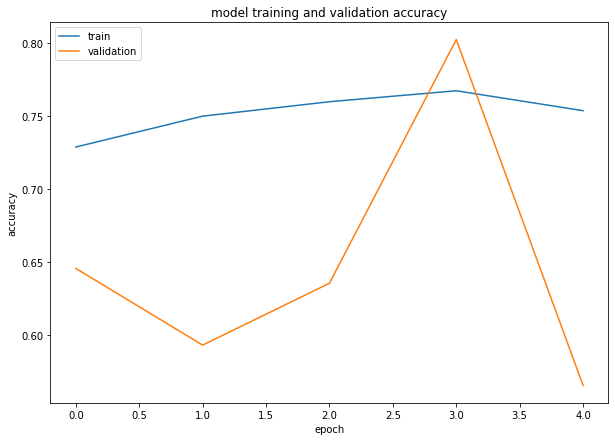

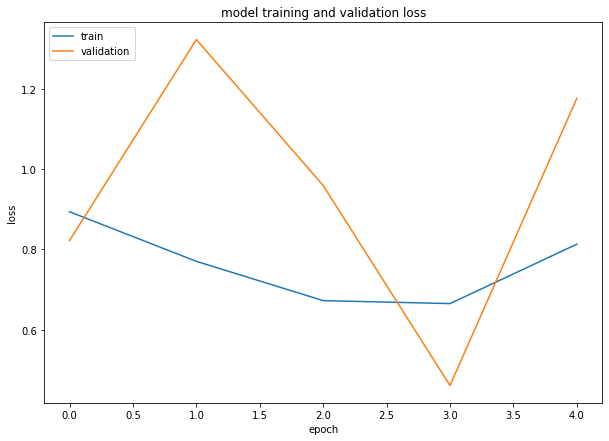

In [15]:
# 4-5: save Keras MLP1 &  model.history as a dictonary of training loss, training accuracy, val_loss, val_accuracy
history_dict = model.history
history_dict.keys()
print(model.history.keys())

# Plot history for accuracy by epoch 
plt.figure(figsize=(10, 7))
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('model training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot history for loss by epoch 
plt.figure(figsize=(10, 7))
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



In [57]:
# 4-6: Check Confusion Matrix, Acccuracy and Recall of Keras MLP1 or 2

start4=time.time()
test_pred_dl=modelnn.predict(x_test)
test_pred_d2 = [1 if x > 0.5 else 0 for x in test_pred_dl]
end4=time.time()
test_time_nn=end4-start4      
print("Test time  NN :", test_time_nn)


#from sklearn import metrics
mlp_conf_matrix = metrics.confusion_matrix(y_test, test_pred_d2)
print (mlp_conf_matrix)

#Print Accuracy
accuracy = metrics.accuracy_score(y_test,test_pred_d2)
print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

#Print Recall
recall = metrics.recall_score(y_test,test_pred_d2)
    
print ("Recall : %s" % "{0:.3%}".format(recall))

Test time  NN : 0.32114672660827637
[[1379  181]
 [ 240  313]]
Accuracy : 80.076%
Recall : 56.600%


### Step 5: Save the best models

In [22]:
#5-1: save the logistics regression model

import pickle
filename = "lr_model.pkl"  

with open(filename, 'wb') as file:  
    pickle.dump(model4, file)
    
    

In [23]:
#5-2: save the KERAS Deep learning Multilayer Perception (MLP) 2

modelnn.save("mlp_model.h5")
